In [1]:
%matplotlib inline
# %config InlineBackend.figure_formats = ['svg']
from scipy.io import loadmat
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mcmc_utils_and_plot import sub_sample_data, scatter_matrix
import time
import math
import scipy.stats as stats 
import scipy.optimize as optimize
import pickle
from ddeint import ddeint

matplotlib.rc('text', usetex = True)
plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=12)  # fontsize of the figure title

In [2]:
def laplace_approx(initial_guess, logpost):
    def neg_post(x):
        """Negative posteror because optimizer is a minimizer"""
        return -logpost(x)
    
    # Gradient free method to obtain optimum
    res = optimize.minimize(neg_post, initial_guess, method='Nelder-Mead') 
    # Gradient method which also approximates the inverse of the hessian
    res = optimize.minimize(neg_post, res.x)

    map_point = res.x
    cov_approx = res.hess_inv
    return map_point, cov_approx

def autocorrelation(samples, maxlag=100, step=1):  
    # Get the shapes
    ndim = samples.shape[1]
    nsamples = samples.shape[0]    
    
    # Compute the mean
    mean = np.mean(samples, axis=0)
    
    # Compute the denominator, which is variance
    denominator = np.zeros((ndim))
    for ii in range(nsamples):
        denominator = denominator + (samples[ii, :] - mean)**2
    
    lags = np.arange(0, maxlag, step)
    autos = np.zeros((len(lags), ndim))
    for zz, lag in enumerate(lags):
        autos[zz, :] = np.zeros((ndim))
        # compute the covariance between all samples *lag apart*
        for ii in range(nsamples - lag):
            autos[zz,:] = autos[zz, :] + (samples[ii,:]-mean)*(samples[ii + lag,:] -mean)
        autos[zz, :] = autos[zz, :]/denominator
    return lags, autos

In [3]:
class adaptive_metropolis_proposal(object):
    def __init__(self, dim, sd=None, t0=50, max_samples=10000, init_cov=None, eps=1e-8):
        self.dim = dim
        self.sd = sd
        self.init_cov = init_cov
        if sd is None:
            self.sd = (2.4**2) / dim
        if init_cov is None:
            self.init_cov = self.sd * np.eye(dim)

        self.eps = eps
        self.t0 = t0
        self.num_samples = 0
        self.samples = np.zeros((max_samples, self.dim))
        self.current_cov = np.copy(self.init_cov)
        self.current_sqrt = np.linalg.cholesky(self.current_cov)
        self.current_mean = np.zeros(self.dim)
    def sampler1(self, current_sample):
        """Sampler, mean and cov are updated until last accepted sample!"""
        if self.num_samples > 1:
            self.samples[self.num_samples, :] = current_sample
            old_mean = np.copy(self.current_mean)
            k = self.num_samples
            self.current_mean = k/(k+1)*old_mean+1/(k+1)*current_sample
            self.num_samples = self.num_samples + 1
            self.current_cov = ((k-1)/k*self.current_cov + self.sd/k*(self.eps*np.eye(self.dim)+k*np.outer(old_mean,old_mean)
                                -(k+1)*np.outer(self.current_mean,self.current_mean)+np.outer(current_sample,current_sample)))
        else:
            self.num_samples = self.num_samples + 1
            self.current_mean = current_sample       
        if self.num_samples > self.t0:
            self.current_sqrt = np.linalg.cholesky(self.current_cov)
        return current_sample + np.dot(self.current_sqrt, np.random.randn(self.dim))
    def sampler2(self, current_sample,gamma = 0.5):
        """Sampler"""
        self.samples[self.num_samples, :] = current_sample
        return current_sample + gamma*np.dot(self.current_sqrt, np.random.randn(self.dim))
    def logpdf(self, current_sample, candidate,gamma = 1):
        """Logpdf evaluator"""
        delta = candidate - current_sample
        return -0.5 * np.dot(delta, np.linalg.solve(gamma*self.current_cov, delta))

def mh_acceptance_prob(current_target_logpdf, proposed_target_logpdf, current_sample, proposed_sample, proposal_func): 
    prop_reverse = proposal_func(proposed_sample, current_sample)
    prop_forward = proposal_func(current_sample, proposed_sample)
    check = proposed_target_logpdf - current_target_logpdf + prop_reverse - prop_forward
    if check < 0:
        return np.exp(check)
    else:
        return 1

def dr_acceptance_prob(current_target_logpdf,proposed_target_logpdf1,proposed_target_logpdf2, current_sample, proposed_sample1, proposed_sample2, proposal_func1, proposal_func2):
    prop_reverse1 = proposal_func1(proposed_sample1, proposed_sample2)
    prop_forward1 = proposal_func1(current_sample, proposed_sample1)
    
    prop_reverse2 = proposal_func2(proposed_sample2, current_sample)
    prop_forward2 = proposal_func2(current_sample, proposed_sample2)
    
    log_reverse = np.log(1-mh_acceptance_prob(current_target_logpdf,proposed_target_logpdf1, proposed_sample2, proposed_sample1, proposal_func1))
    log_forward = np.log(1-mh_acceptance_prob(current_target_logpdf,proposed_target_logpdf1, current_sample, proposed_sample1, proposal_func1))
    
    
    check = proposed_target_logpdf2 - current_target_logpdf + prop_reverse1 - prop_forward1 + prop_reverse2 - prop_forward2 +log_reverse-log_forward
    if check < 0:
        return np.exp(check)
    else:
        return 1
    
    
def drmcmc(starting_sample, num_samples, target_logpdf, proposal_logpdf1, proposal_logpdf2, proposal_sampler1,proposal_sampler2):
    d = starting_sample.shape[0]
    samples = np.zeros((num_samples, d))
    samples[0, :] = starting_sample
    current_target_logpdf = target_logpdf(samples[0, :])
    
    num_accept = 0
    for ii in range(1, num_samples):
        # propose
        proposed_sample1 = proposal_sampler1(samples[ii-1, :])
        proposed_target_logpdf1 = target_logpdf(proposed_sample1)
        # determine acceptance probability
        a = mh_acceptance_prob(current_target_logpdf, proposed_target_logpdf1, samples[ii-1,:], proposed_sample1, proposal_logpdf1)
        # Accept or reject the sample
        if a == 1: #guaranteed to accept
            samples[ii, :] = proposed_sample1
            current_target_logpdf = proposed_target_logpdf1
            num_accept += 1
        else:
            u = np.random.rand()
            if u < a: # accept
                samples[ii, :] = proposed_sample1
                current_target_logpdf = proposed_target_logpdf1
                num_accept += 1
            else: # propose again
                proposed_sample2 = proposal_sampler2(samples[ii-1, :])
                proposed_target_logpdf2 = target_logpdf(proposed_sample2)
                a = dr_acceptance_prob(current_target_logpdf, proposed_target_logpdf1,proposed_target_logpdf2,samples[ii-1,:], proposed_sample1, proposed_sample2, proposal_logpdf1, proposal_logpdf2)
                if a == 1:
                    samples[ii, :] = proposed_sample2
                    current_target_logpdf = proposed_target_logpdf2
                    num_accept += 1
                else:
                    u = np.random.rand()
                    if u < a: # accept
                        samples[ii, :] = proposed_sample2
                        current_target_logpdf = proposed_target_logpdf2
                        num_accept += 1
                    else: # reject
                        samples[ii, :] = samples[ii-1, :]
    return samples, num_accept / float(num_samples-1)

def gamma_log_prior(param, a = 1.5):
    '''different prior distribution? gamma for tau,alpha,beta,kappa, independent'''
    return np.sum(stats.gamma.logpdf(param, a))

def uniform_log_prior(param, a = 6):
    '''different prior distribution? gamma for tau,alpha,beta,kappa, independent'''
    return np.sum(stats.uniform.logpdf(param, scale=6))

###  For two dimension outputs
###  7 datasets, Npts is a 7by1 array, different observe functions in dde_fun, so we need a list of function
def dvdt_predictor_2d(param, dde_fun, observer_list, Npts, taumax):
    '''if propose tau < 0 or >taumax, then skip simulation just assign out_pred all 0'''
    Npts = Npts-int(taumax/0.1)-1  # the derivative is one sample shorter than the dataset
    Npts_total = np.sum(Npts)
    out_pred = np.zeros((2,Npts_total))
    ID = np.cumsum(Npts)
    if param[0]<0 or param[0]> taumax:
        flag = 1
    else:
        flag = 0
        for i in range(len(observer_list)):
            tsim = np.arange(taumax, (Npts[i]+int(taumax/0.1))*0.1, 0.1)
            out_pred[:,ID[i]-Npts[i]:ID[i]]= dde_fun(tsim,param,observer_list[i])
    return out_pred, flag

# ### http://gregorygundersen.com/blog/2020/12/12/group-multivariate-normal-pdf/
def multiple_logpdfs(x, means, covs):
    # Thankfully, NumPy broadcasts `eigh`.
    vals, vecs = np.linalg.eigh(covs)
    # Compute the log determinants across the second axis.
    logdets    = np.sum(np.log(vals), axis=1)
    # Invert the eigenvalues.
    valsinvs   = 1./vals
    # Add a dimension to `valsinvs` so that NumPy broadcasts appropriately.
    Us         = vecs * np.sqrt(valsinvs)[:, None]
    devs       = x - means
    # Use `einsum` for matrix-vector multiplications across the first dimension.
    devUs      = np.einsum('ni,nij->nj', devs, Us)
    # Compute the Mahalanobis distance by squaring each term and summing.
    mahas      = np.sum(np.square(devUs), axis=1)
    # Compute and broadcast scalar normalizers.
    dim        = len(vals[0])
    log2pi     = np.log(2 * np.pi)
    return -0.5 * (dim * log2pi + mahas + logdets)

def dvdt_log_likelihood_2d(param, dde_fun, observe_funs, Npts, taumax, outputs, cov):
    out_pred, flag = dvdt_predictor_2d(param, dde_fun,observe_funs, Npts, taumax)
    # still assume Gaussian noise, var is a vector
    if flag:
        log_like = -math.inf
    else:       
        log_like = np.sum(multiple_logpdfs(out_pred.T,outputs.T,np.tile(cov,(np.shape(out_pred)[1],1,1))))
    return log_like

# def dvdt_log_posterior_2d(param, dde_fun,observe_funs, Npts, taumax, outputs, guess_noise_cov,a=1.5):
#     return gamma_log_prior(param,a) + dvdt_log_likelihood_2d(param, dde_fun, observe_funs,Npts, taumax, outputs, guess_noise_cov)
def dvdt_log_posterior_2d(param, dde_fun,observe_funs, Npts, taumax, outputs, guess_noise_cov,a=6):
    return uniform_log_prior(param,taumax) + dvdt_log_likelihood_2d(param, dde_fun, observe_funs,Npts, taumax, outputs, guess_noise_cov)

In [4]:
amax = 3
amin = -7
kappa = 0.6
alpha = 0.4
beta = 0.5
vmax = 30
hst = 5
hgo = hst+vmax/kappa
P = 50000    # power limit / 75000
m = 1770
a_up = lambda v: np.minimum(amax*np.ones(np.shape(v)),P/m/np.abs(v))
satfun = lambda x,v: (amin<=x)*(x<=a_up(v))*x+(x<amin)*amin+(x>a_up(v))*a_up(v)
satfun_noPL = lambda x: (amin<=x)*(x<=amax)*x+(x<amin)*amin+(x>amax)*amax
Vfun = lambda x: (hst<=x)*(x<=hgo)*kappa*(x-hst)+(x>hgo)*vmax
Wfun =  lambda x: (x<=vmax)*x+(x>vmax)*vmax

## derivative
def CAV_4dvdt_2d(tsim, param, observe_fun):
    '''param[0] is delay, param[1] is c, param[2] is b, param[3] is a '''
    h,v,vL = observe_fun(tsim)
    hdelay, vdelay, vLdelay = observe_fun(tsim-param[0])
    dhdt = vL-v
#     dvdt = satfun_noPL(alpha*(Vfun(hdelay)-vdelay)+beta*(Wfun(vLdelay)-vdelay))-param[1]/1000*v**2-0.01*param[2]*v-0.1*param[3]
    dvdt = (satfun(alpha*(Vfun(hdelay)-vdelay)+beta*(Wfun(vLdelay)-vdelay),v)
            -param[1]/1000*v**2-0.01*param[2]*v-0.1*param[3])
    return np.array([dhdt,dvdt])

def CAV_3dvdt_2d(tsim, param,observe_fun):
    '''param[0] is delay, param[1] is c, param[2] is a '''
    h,v,vL = observe_fun(tsim)
    hdelay, vdelay, vLdelay = observe_fun(tsim-param[0])
    dhdt = vL-v
#     dvdt = satfun_noPL(alpha*(Vfun(hdelay)-vdelay)+beta*(Wfun(vLdelay)-vdelay))-param[1]/1000*v**2-0.1*param[2]
    dvdt = (satfun(alpha*(Vfun(hdelay)-vdelay)+beta*(Wfun(vLdelay)-vdelay),v)
            -param[1]/1000*v**2-0.1*param[2])
    return np.array([dhdt,dvdt])

def CAV_2dvdt_2d(tsim, param,observe_fun):
    '''param[0] is delay, param[1] is c'''
    h,v,vL = observe_fun(tsim)
    hdelay, vdelay, vLdelay = observe_fun(tsim-param[0])
    dhdt = vL-v
#     dvdt = satfun_noPL(alpha*(Vfun(hdelay)-vdelay)+beta*(Wfun(vLdelay)-vdelay))-param[1]/1000*v**2
    dvdt = (satfun(alpha*(Vfun(hdelay)-vdelay)+beta*(Wfun(vLdelay)-vdelay),v)
            -param[1]/1000*v**2)
    return np.array([dhdt,dvdt])

## simulation
def CAV_4param(Y, t, d, c, b, a):
    '''for simulation'''
    h,v = Y(t)
    hdelay,vdelay = Y(t-d)
    vL = vLfun(t)
    vLdelay = vLfun(t-d)
    dhdt = vL-v
#     dvdt = satfun_noPL(alpha*(Vfun(hdelay)-vdelay)+beta*(Wfun(vLdelay)-vdelay))-c/1000*v**2-0.01*b*v-0.1*a
    dvdt = (satfun(alpha*(Vfun(hdelay)-vdelay)+beta*(Wfun(vLdelay)-vdelay),v)
            -c/1000*v**2-0.01*b*v-0.1*a)
    return np.array([dhdt,dvdt])

def CAV_3param(Y, t, d, c, a):
    h,v = Y(t)
    hdelay,vdelay = Y(t-d)
    vL = vLfun(t)
    vLdelay = vLfun(t-d)
    dhdt = vL-v
#     dvdt = satfun_noPL(alpha*(Vfun(hdelay)-vdelay)+beta*(Wfun(vLdelay)-vdelay))-c/1000*v**2-0.1*a
    dvdt = (satfun(alpha*(Vfun(hdelay)-vdelay)+beta*(Wfun(vLdelay)-vdelay),v)
            -c/1000*v**2-0.1*a)
    return np.array([dhdt,dvdt])

def CAV_2param(Y, t, d, c):
    h,v = Y(t)
    hdelay,vdelay = Y(t-d)
    vL = vLfun(t)
    vLdelay = vLfun(t-d)
    dhdt = vL-v
#     dvdt = satfun_noPL(alpha*(Vfun(hdelay)-vdelay)+beta*(Wfun(vLdelay)-vdelay))-c/1000*v**2
    dvdt = (satfun(alpha*(Vfun(hdelay)-vdelay)+beta*(Wfun(vLdelay)-vdelay),v)
            -c/1000*v**2)
    return np.array([dhdt,dvdt])


## uniform prior for deceleration data

In [37]:
# read all relavent dats
# ave lead velocity  2.0, 6.3, 11.4, 14.5, 17.1, 21.7, 20.9, 22.0, 22.3, 25.1
# ave velocity       2.0, 6.5, 11.7, 14.8, 17.6, 22.1, 21.4, 22.8, 23.4, 25.8
# ave headway        8.0, 16.7, 25.6, 30.7,35.7, 44.8, 44.5, 49.7, 52.7, 72.4 (acceleration limit is nonlinear)

# Read in all data, make 
h_collect = (5,10,15,20,25,30,50)
taumax = 6
dt = 0.1

# dec, last 10 second
npoints = 160
Npts=[]
data_h = []
data_vl = []
data_v = []
data_dv = []
data_dh = []
tt = []
observe_funs = []
output_2d = []
    
for i in range(len(h_collect)):
    h = h_collect[i]
    fname = 'data\RealAVData\RealAVhstar'+str(h)+'.mat'
    data = loadmat(fname)['D']
    '''first column is headway of CAV, second column is the speed difference,
    third column is the velocity of CAV and last column is the acceleration of CAV.'''
    Npts.append(npoints)     # number of data points
    st = len(data)-npoints
    data_h.append(data[st:st+Npts[i],0])                      # inference from h0
    data_vl.append(data[st:st+Npts[i],1]+data[st:st+Npts[i],2])  # input to the system
    data_v.append(data[st:st+Npts[i],2])                     # or inference from v0
    data_dv.append(np.diff(data_v[i])/dt)
    data_dh.append(np.diff(data_h[i])/dt)
    tt.append(np.linspace(0, Npts[i]*0.1, num=Npts[i]))  # reference time
    observe_funs.append(lambda t,j=i: np.array([np.interp(t, tt[j], data_h[j]),
                                                np.interp(t, tt[j], data_v[j]),
                                                np.interp(t, tt[j], data_vl[j])]))
    
Npts = np.array(Npts)
N_out = Npts-int(taumax/0.1)-1  # the derivative is one sample shorter than the dataset
Npts_total = np.sum(N_out)
output_2d = np.zeros((2,Npts_total))
ID = np.cumsum(N_out)
for i in range(len(h_collect)):
    output_2d[:,ID[i]-N_out[i]:ID[i]]=np.vstack((data_dh[i][int(taumax/0.1):],data_dv[i][int(taumax/0.1):]))
    
dim = 4
noise_std = np.array([[0.2,0],[0,0.2]])                        # this represent the variance of noise in both states
guess_noise_var = noise_std**2/dt**2                         # this represent the variance of noise in state derivatives
# 2D outputs
post_use_2d = lambda param: dvdt_log_posterior_2d(param, CAV_4dvdt_2d,observe_funs, Npts, taumax, output_2d, guess_noise_var)
guess = stats.uniform.rvs(scale = 6, size=dim) # random guess
start_time = time.time()
map_point, cov_laplace = laplace_approx(guess, post_use_2d)
print(time.time() - start_time, "seconds")
print(map_point)
print(cov_laplace)

0.6521716117858887 seconds
[3.35212549e-01 5.83698906e-01 3.48227422e-06 2.24482373e-09]
[[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]]


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:697: RuntimeWarning: invalid value encountered in double_scalars
  df = (f(*((xk + d,) + args)) - f0) / d[k]


In [57]:
num_samples = 10000
dim = 4

initial_sample = map_point
initial_cov = cov_laplace

target_logpdf = lambda param: dvdt_log_posterior_2d(param, CAV_4dvdt_2d, observe_funs, Npts, taumax,output_2d, guess_noise_var, a=1.5)

DRAM = adaptive_metropolis_proposal(dim, sd=None, t0=100, max_samples=num_samples, init_cov=initial_cov, eps=1e-8)
sampler1 = DRAM.sampler1
sampler_logpdf1 = DRAM.logpdf
sampler2 = DRAM.sampler2
sampler_logpdf2 = lambda current_sample, candidate: DRAM.logpdf(current_sample, candidate, gamma = 0.5)
start_time = time.time()
dram_samples, dram_ar = drmcmc(initial_sample, num_samples, target_logpdf, sampler_logpdf1, sampler_logpdf2, sampler1,sampler2)
print(time.time() - start_time, "seconds")
print("Accepted Samples Ratio:", dram_ar)

# results_fname = "combined\\power_limit\samples_4param_PL_acc_std02.p"
# pickle.dump([dram_samples,dram_ar,map_point,cov_laplace], open(results_fname, "wb" ))
# del dram_samples,dram_ar,map_point,cov_laplace

34.399136543273926 seconds
Accepted Samples Ratio: 0.20282028202820282


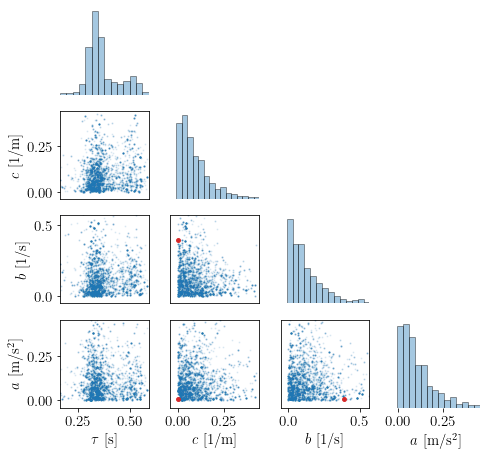

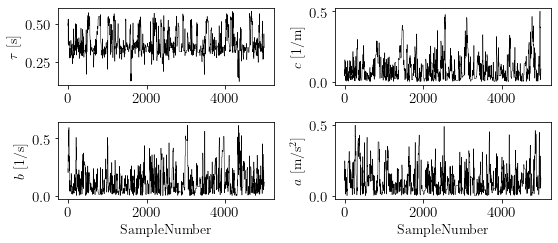

In [58]:
samples_sub = sub_sample_data(dram_samples, frac_burn=0.5, frac_use=0.9)

plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize

fig, axs, gs = scatter_matrix([samples_sub], labels=
                              [r'$\tau$ $\mathrm{[s]}$', '$c$ $\mathrm{[1/m]}$', '$b$ $\mathrm{[1/s]}$', '$a$ $\mathrm{[m/s^2]}$'], 
                              hist_plot=False, gamma=0.1, nbins=70)
# axs[0].set_xlim((0.4,0.8))
# axs[1].set_xlim((0,0.6))
# axs[2].set_xlim((0,0.8))
# axs[3].set_xlim((0,0.6))
# axs[3].set_xticks((0,0.2,0.4,0.6))

# axs[4].set_ylim((0,0.6)) # top tau-c
# axs[4].set_yticks((0,0.2,0.4,0.6))
# axs[4].set_xlim((0.4,0.8))
axs[4].scatter(map_point[0],map_point[1],s=15,c = '#d62728',zorder=5000)
axs[4].set_rasterized(True)

# axs[8].set_ylim((0,0.8)) # mid 1  tau-b
# axs[8].set_yticks((0,0.4,0.8))
# axs[8].set_xlim((0.4,0.8))
axs[8].scatter(map_point[0],map_point[2],s=15,c = '#d62728',zorder=5000)
axs[8].set_rasterized(True)

# axs[9].set_ylim((0,0.8)) # mid  c-b
# axs[9].set_xlim((0,0.6))
axs[9].scatter(map_point[1],map_point[2],s=15,c = '#d62728',zorder=5000)
axs[9].set_rasterized(True)


# axs[12].set_ylim((0,0.6)) # bot 1 tau-a
# axs[12].set_yticks((0,0.2,0.4,0.6))
# axs[12].set_xlim((0.4,0.8))
# axs[12].set_xticks((0.4,0.6,0.8))
axs[12].scatter(map_point[0],map_point[3],s=15,c = '#d62728',zorder=5000)
axs[12].set_rasterized(True)

# axs[13].set_ylim((0,0.6))
# axs[13].set_xlim((0,0.6)) # bot 2 c-a
# axs[13].set_xticks((0,0.2,0.4,0.6)) # bot 2
axs[13].scatter(map_point[1],map_point[3],s=15,c = '#d62728',zorder=5000)
axs[13].set_rasterized(True)

# axs[14].set_ylim((0,0.6))
# axs[14].set_xlim((0,0.8)) # bot 3 b-a
# axs[14].set_xticks((0,0.4,0.8)) # bot 3
axs[14].scatter(map_point[2],map_point[3],s=15,c = '#d62728',zorder=5000)
axs[14].set_rasterized(True)

fig.set_size_inches(7,7)
plt.tight_layout(rect=[0, 0.01, 1, 0.95])
plt.savefig('figures\marginal_'+str(dim)+'param_com_PL.svg',dpi=500)

fig, axs = plt.subplots(2,2, figsize=(8,4))
axs[0,0].plot(samples_sub[:, 0], '-k',lw=0.5)
axs[0,0].set_ylabel(r'$\tau$ $\mathrm{[s]}$', fontsize=14)
# axs[0,0].set_yticks((0.4,0.6,0.8))

axs[0,1].plot(samples_sub[:, 1], '-k',lw=0.5)
axs[0,1].set_ylabel(r'$c$ $\mathrm{[1/m]}$', fontsize=14)
# axs[0,1].set_yticks((0,0.2,0.4,0.6))

axs[1,0].plot(samples_sub[:, 2], '-k',lw=0.5)
axs[1,0].set_ylabel('$b$ $\mathrm{[1/s]}$', fontsize=14)
# axs[1,0].set_yticks((0,0.5,1,1.5))
axs[1,0].set_xlabel('$\mathrm{Sample Number}$', fontsize=14)

axs[1,1].plot(samples_sub[:, 3], '-k',lw=0.5)
# axs[1,1].set_yticks((0,0.5,1))
axs[1,1].set_ylabel('$a$ $\mathrm{[m/s^2]}$', fontsize=14)
axs[1,1].set_xlabel('$\mathrm{Sample Number}$', fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

## All data

In [38]:
# read all relavent dats
# ave lead velocity  2.0, 6.3, 11.4, 14.5, 17.1, 21.7, 20.9, 22.0, 22.3, 25.1
# ave velocity       2.0, 6.5, 11.7, 14.8, 17.6, 22.1, 21.4, 22.8, 23.4, 25.8
# ave headway        8.0, 16.7, 25.6, 30.7,35.7, 44.8, 44.5, 49.7, 52.7, 72.4 (acceleration limit is nonlinear)

# Read in all data, make 
h_collect = (5,10,15,20,25,30,50)
taumax = 6
dt = 0.1

st = 0
Npts=[]
data_h = []
data_vl = []
data_v = []
data_dv = []
data_dh = []
tt = []
observe_funs = []
output_2d = []
    
for i in range(len(h_collect)):
    h = h_collect[i]
    fname = 'data\RealAVData\RealAVhstar'+str(h)+'.mat'
    data = loadmat(fname)['D']
    '''first column is headway of CAV, second column is the speed difference,
    third column is the velocity of CAV and last column is the acceleration of CAV.'''
    Npts.append(len(data))
    data_h.append(data[st:st+Npts[i],0])                      # inference from h0
    data_vl.append(data[st:st+Npts[i],1]+data[st:st+Npts[i],2])  # input to the system
    data_v.append(data[st:st+Npts[i],2])                     # or inference from v0
    data_dv.append(np.diff(data_v[i])/dt)
    data_dh.append(np.diff(data_h[i])/dt)
    tt.append(np.linspace(st*0.1, (st+Npts[i])*0.1, num=Npts[i]))  # reference time
    observe_funs.append(lambda t,j=i: np.array([np.interp(t, tt[j], data_h[j]),
                                                np.interp(t, tt[j], data_v[j]),
                                                np.interp(t, tt[j], data_vl[j])]))
    
Npts = np.array(Npts)
N_out = Npts-int(taumax/0.1)-1  # the derivative is one sample shorter than the dataset
Npts_total = np.sum(N_out)
output_2d = np.zeros((2,Npts_total))
ID = np.cumsum(N_out)
for i in range(len(h_collect)):
    output_2d[:,ID[i]-N_out[i]:ID[i]]=np.vstack((data_dh[i][int(taumax/0.1):],data_dv[i][int(taumax/0.1):]))

##  Acceleration data

In [5]:
# read all relavent dats
# ave lead velocity  2.0, 6.3, 11.4, 14.5, 17.1, 21.7, 20.9, 22.0, 22.3, 25.1
# ave velocity       2.0, 6.5, 11.7, 14.8, 17.6, 22.1, 21.4, 22.8, 23.4, 25.8
# ave headway        8.0, 16.7, 25.6, 30.7,35.7, 44.8, 44.5, 49.7, 52.7, 72.4 (acceleration limit is nonlinear)

# Read in all data, make 
h_collect = (5,10,15,20,25,30,50)
taumax = 6
dt = 0.1

# acc, from the beginning, takes the first 10 second
st = 0
npoints = 160
Npts=[]
data_h = []
data_vl = []
data_v = []
data_dv = []
data_dh = []
tt = []
observe_funs = []
output_2d = []
    
for i in range(len(h_collect)):
    h = h_collect[i]
    fname = 'data\RealAVData\RealAVhstar'+str(h)+'.mat'
    data = loadmat(fname)['D']
    '''first column is headway of CAV, second column is the speed difference,
    third column is the velocity of CAV and last column is the acceleration of CAV.'''
    Npts.append(npoints)     # number of data points
    data_h.append(data[st:st+Npts[i],0])                      # inference from h0
    data_vl.append(data[st:st+Npts[i],1]+data[st:st+Npts[i],2])  # input to the system
    data_v.append(data[st:st+Npts[i],2])                     # or inference from v0
    data_dv.append(np.diff(data_v[i])/dt)
    data_dh.append(np.diff(data_h[i])/dt)
    tt.append(np.linspace(0, Npts[i]*0.1, num=Npts[i]))      # reference time
    observe_funs.append(lambda t,j=i: np.array([np.interp(t, tt[j], data_h[j]),
                                                np.interp(t, tt[j], data_v[j]),
                                                np.interp(t, tt[j], data_vl[j])]))
    
Npts = np.array(Npts)
N_out = Npts-int(taumax/0.1)-1  # the derivative is one sample shorter than the dataset
Npts_total = np.sum(N_out)
output_2d = np.zeros((2,Npts_total))
ID = np.cumsum(N_out)
for i in range(len(h_collect)):
    output_2d[:,ID[i]-N_out[i]:ID[i]]=np.vstack((data_dh[i][int(taumax/0.1):],data_dv[i][int(taumax/0.1):]))

## Deceleration data

In [204]:
# read all relavent dats
# ave lead velocity  2.0, 6.3, 11.4, 14.5, 17.1, 21.7, 20.9, 22.0, 22.3, 25.1
# ave velocity       2.0, 6.5, 11.7, 14.8, 17.6, 22.1, 21.4, 22.8, 23.4, 25.8
# ave headway        8.0, 16.7, 25.6, 30.7,35.7, 44.8, 44.5, 49.7, 52.7, 72.4 (acceleration limit is nonlinear)

# Read in all data, make 
h_collect = (5,10,15,20,25,30,50)
taumax = 6
dt = 0.1

# dec, last 10 second
npoints = 160
Npts=[]
data_h = []
data_vl = []
data_v = []
data_dv = []
data_dh = []
tt = []
observe_funs = []
output_2d = []
    
for i in range(len(h_collect)):
    h = h_collect[i]
    fname = 'data\RealAVData\RealAVhstar'+str(h)+'.mat'
    data = loadmat(fname)['D']
    '''first column is headway of CAV, second column is the speed difference,
    third column is the velocity of CAV and last column is the acceleration of CAV.'''
    Npts.append(npoints)     # number of data points
    st = len(data)-npoints
    data_h.append(data[st:st+Npts[i],0])                      # inference from h0
    data_vl.append(data[st:st+Npts[i],1]+data[st:st+Npts[i],2])  # input to the system
    data_v.append(data[st:st+Npts[i],2])                     # or inference from v0
    data_dv.append(np.diff(data_v[i])/dt)
    data_dh.append(np.diff(data_h[i])/dt)
    tt.append(np.linspace(0, Npts[i]*0.1, num=Npts[i]))  # reference time
    observe_funs.append(lambda t,j=i: np.array([np.interp(t, tt[j], data_h[j]),
                                                np.interp(t, tt[j], data_v[j]),
                                                np.interp(t, tt[j], data_vl[j])]))
    
Npts = np.array(Npts)
N_out = Npts-int(taumax/0.1)-1  # the derivative is one sample shorter than the dataset
Npts_total = np.sum(N_out)
output_2d = np.zeros((2,Npts_total))
ID = np.cumsum(N_out)
for i in range(len(h_collect)):
    output_2d[:,ID[i]-N_out[i]:ID[i]]=np.vstack((data_dh[i][int(taumax/0.1):],data_dv[i][int(taumax/0.1):]))

## Sampling

In [42]:
dim = 4
noise_std = np.array([[0.2,0],[0,0.2]])                        # this represent the variance of noise in both states
guess_noise_var = noise_std**2/dt**2                         # this represent the variance of noise in state derivatives


# 2D outputs
post_use_2d = lambda param: dvdt_log_posterior_2d(param, CAV_4dvdt_2d,observe_funs, Npts, taumax, output_2d, guess_noise_var, a=1.5)
guess = stats.gamma.rvs(1.5, size=dim) # random guess
start_time = time.time()
map_point, cov_laplace = laplace_approx(guess, post_use_2d)
print(time.time() - start_time, "seconds")
print(map_point)
print(cov_laplace)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:697: RuntimeWarning: invalid value encountered in double_scalars
  df = (f(*((xk + d,) + args)) - f0) / d[k]


6.430250406265259 seconds
[5.65824597e-01 2.20163288e-01 3.81767476e-07 9.84754661e-01]
[[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]]


In [43]:
num_samples = 10000
dim = 4

initial_sample = map_point
initial_cov = 0.2*cov_laplace

target_logpdf = lambda param: dvdt_log_posterior_2d(param, CAV_4dvdt_2d, observe_funs, Npts, taumax,output_2d, guess_noise_var, a=1.5)

DRAM = adaptive_metropolis_proposal(dim, sd=None, t0=100, max_samples=num_samples, init_cov=initial_cov, eps=1e-8)
sampler1 = DRAM.sampler1
sampler_logpdf1 = DRAM.logpdf
sampler2 = DRAM.sampler2
sampler_logpdf2 = lambda current_sample, candidate: DRAM.logpdf(current_sample, candidate, gamma = 0.5)
start_time = time.time()
dram_samples, dram_ar = drmcmc(initial_sample, num_samples, target_logpdf, sampler_logpdf1, sampler_logpdf2, sampler1,sampler2)
print(time.time() - start_time, "seconds")
print("Accepted Samples Ratio:", dram_ar)

results_fname = "combined\\power_limit\samples_4param_PL_std02_uni.p"
pickle.dump([dram_samples,dram_ar,map_point,cov_laplace], open(results_fname, "wb" ))
del dram_samples,dram_ar,map_point,cov_laplace

235.1377158164978 seconds
Accepted Samples Ratio: 0.2544254425442544


In [273]:
dim = 3
# 2D outputs
post_use_2d = lambda param: dvdt_log_posterior_2d(param, CAV_3dvdt_2d, observe_funs, Npts, taumax, output_2d, guess_noise_var, a=1.5)
guess = stats.gamma.rvs(1.5, size=dim) # random guess
guess[0]=0.5
start_time = time.time()
map_point, cov_laplace = laplace_approx(guess, post_use_2d)
print(time.time() - start_time, "seconds")
print(map_point)
print(cov_laplace)

0.7288665771484375 seconds
[0.74654087 0.6000257  0.4105052 ]
[[ 1.36554143e-07 -5.05458787e-06 -9.71396178e-06]
 [-5.05458787e-06  7.53143621e-03  1.46107142e-02]
 [-9.71396178e-06  1.46107142e-02  2.91955956e-02]]


In [274]:
num_samples = 10000
dim = 3
initial_sample = map_point
initial_cov = cov_laplace

target_logpdf = lambda param: dvdt_log_posterior_2d(param, CAV_3dvdt_2d,observe_funs, Npts, taumax,output_2d, guess_noise_var, a=1.5)

DRAM = adaptive_metropolis_proposal(dim, sd=None, t0=100, max_samples=num_samples, init_cov=initial_cov, eps=1e-8)

sampler1 = DRAM.sampler1
sampler_logpdf1 = DRAM.logpdf
sampler2 = DRAM.sampler2
sampler_logpdf2 = lambda current_sample, candidate: DRAM.logpdf(current_sample, candidate, gamma = 0.5)
start_time = time.time()
dram_samples, dram_ar = drmcmc(initial_sample, num_samples, target_logpdf, sampler_logpdf1, sampler_logpdf2, sampler1,sampler2)
print(time.time() - start_time, "seconds")
print("Accepted Samples Ratio:", dram_ar)

results_fname = "combined\\power_limit\samples_3param_PL_std005.p"
pickle.dump([dram_samples,dram_ar,map_point,cov_laplace], open(results_fname, "wb" ))
del dram_samples,dram_ar,map_point,cov_laplace

49.64930033683777 seconds
Accepted Samples Ratio: 0.6511651165116512


In [275]:
dim = 2
# 2D outputs
post_use_2d = lambda param: dvdt_log_posterior_2d(param, CAV_2dvdt_2d,observe_funs, Npts, taumax, output_2d, guess_noise_var, a=1.5)
guess = stats.gamma.rvs(1.5, size=dim) # random guess
guess[0]=0.5
start_time = time.time()
map_point, cov_laplace = laplace_approx(guess, post_use_2d)
print(time.time() - start_time, "seconds")
print(map_point)
print(cov_laplace)

1.2293622493743896 seconds
[0.74654088 0.71268868]
[[1.10714067e-06 9.35754979e-06]
 [9.35754979e-06 8.72998705e-02]]


In [276]:
num_samples = 10000
dim = 2

initial_sample = map_point
initial_cov = cov_laplace

target_logpdf = lambda param: dvdt_log_posterior_2d(param, CAV_2dvdt_2d, observe_funs, Npts, taumax,output_2d, guess_noise_var, a=1.5)

DRAM = adaptive_metropolis_proposal(dim, sd=None, t0=100, max_samples=num_samples, init_cov=initial_cov, eps=1e-8)
sampler1 = DRAM.sampler1
sampler_logpdf1 = DRAM.logpdf
sampler2 = DRAM.sampler2
sampler_logpdf2 = lambda current_sample, candidate: DRAM.logpdf(current_sample, candidate, gamma = 0.5)
start_time = time.time()
dram_samples, dram_ar = drmcmc(initial_sample, num_samples, target_logpdf, sampler_logpdf1, sampler_logpdf2, sampler1,sampler2)
print(time.time() - start_time, "seconds")
print("Accepted Samples Ratio:", dram_ar)

results_fname = "combined\\power_limit\samples_2param_PL_std005.p"
pickle.dump([dram_samples,dram_ar,map_point,cov_laplace], open(results_fname, "wb" ))
del dram_samples,dram_ar,map_point,cov_laplace

56.753490686416626 seconds
Accepted Samples Ratio: 0.7041704170417041


## Plot + simulation

In [74]:
# simulation 
h_ave = 50
fname = 'data\RealAVData\RealAVhstar'+str(h_ave)+'.mat'
data = loadmat(fname)['D']
'''first column is headway of CAV, second column is the speed difference,
third column is the velocity of CAV and last column is the acceleration of CAV.'''
Npts_single = len(data)
dt = 0.1
st = 0
data_h_single = data[st:st+Npts_single,0]                      # inference from h0
data_vl_single = data[st:st+Npts_single,1]+data[st:st+Npts_single,2]  # input to the system
data_v_single = data[st:st+Npts_single,2]                      # or inference from v0
data_dv_single = np.diff(data_v_single)/dt
data_dh_single = np.diff(data_h_single)/dt
tt_single = np.linspace(st*0.1, (st+Npts_single)*0.1, num=Npts_single)  # reference time
tsim = np.linspace(st*0.1+taumax, st*0.1+(Npts_single-1)*0.1, num=Npts_single-1-int(taumax/0.1))   # simulation time
vLfun = lambda t:np.interp(t, tt_single, data_vl_single)
g = lambda t: np.array([np.interp(t, tt_single, data_h_single),np.interp(t, tt_single, data_v_single)])  # history

0.6737673767376737
MAP: [0.72464145 0.40076491]
mean: [0.70687141 0.39728319]
median: [0.72067903 0.3973578 ]
quantile05: [0.56639661 0.31938131]
quantile95: [0.74945668 0.47284578]


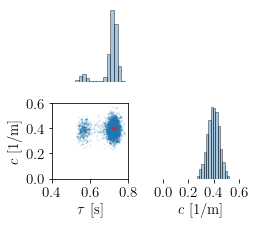

In [10]:
## plot MAP/Mean/STD Simu
dim = 2
results_fname = "combined\\power_limit\samples_2param_2modes_std02.p"
# results_fname = "combined\\power_limit\samples_2param_PL_acc_std01.p"
[dram_samples,dram_ar,map_point,cov_laplace] = pickle.load(open(results_fname, "rb" ))
print(dram_ar)
samples_sub = sub_sample_data(dram_samples, frac_burn=0.5, frac_use=0.9)
fig, axs, gs = scatter_matrix([samples_sub], labels=[r'$\tau$ $\mathrm{[s]}$', '$c$ $\mathrm{[1/m]}$'],
                              hist_plot=False, gamma=0.1, nbins=70)
axs[0].set_xlim((0.4,0.8))     # tau
axs[1].set_xlim((0,0.6))       # c
axs[1].set_xticks((0,0.2,0.4,0.6))

axs[2].set_ylim((0,0.6)) # top tau-c
axs[2].set_yticks((0,0.2,0.4,0.6))
axs[2].set_xlim((0.4,0.8))
axs[2].set_xticks((0.4,0.6,0.8))
axs[2].scatter(map_point[0],map_point[1],s=10,c = '#d62728',zorder=5000)
axs[2].set_rasterized(True)

fig.set_size_inches(3.8,3.6)
plt.tight_layout(rect=[0, 0.01, 1, 0.95])
plt.savefig('figures\marginal_'+str(dim)+'param_com_PL.svg',dpi=500)

mean = np.mean(samples_sub,axis = 0)
median = np.median(samples_sub,axis = 0)
theta_cov = np.cov(samples_sub.T)
theta_std = np.sqrt(np.diag(theta_cov))
theta_quant95 = np.quantile(samples_sub,0.95,axis = 0)
theta_quant05 = np.quantile(samples_sub,0.05,axis = 0)
print('MAP: {}'.format(map_point) )
print('mean: {}'.format(mean))
print('median: {}'.format(median))
print('quantile05: {}'.format(theta_quant05))
print('quantile95: {}'.format(theta_quant95))

In [ ]:
yy_median = ddeint(CAV_2param, g, tsim, fargs=median.tolist())
yy_upb = ddeint(CAV_2param, g, tsim, fargs=theta_quant95.tolist())
yy_lwb = ddeint(CAV_2param, g, tsim, fargs=theta_quant05.tolist())
MSE_h = np.sum((yy_median[:,0]-data_h_single[int(taumax/0.1):-1])**2)/yy_median.shape[0]
MSE_v = np.sum((yy_median[:,1]-data_v_single[int(taumax/0.1):-1])**2)/yy_median.shape[0]

yy_map = ddeint(CAV_2param, g, tsim, fargs=map_point.tolist())
MSE_h_map = np.sum((yy_map[:,0]-data_h_single[int(taumax/0.1):-1])**2)/yy_map.shape[0]
MSE_v_map = np.sum((yy_map[:,1]-data_v_single[int(taumax/0.1):-1])**2)/yy_map.shape[0]

print(np.sqrt(MSE_h))
print(np.sqrt(MSE_v))
matplotlib.rc('text', usetex = True)
fig,axs = plt.subplots(2, 1, figsize=(6.5, 4))
# headway 
axs[0].scatter(tt_single,data_h_single, label = 'data',alpha = 0.3,s = 10)
axs[0].plot(tsim,yy_median[:,0],'red',ls ='-', label = 'median simulation',linewidth=2)
axs[0].fill_between(tsim,yy_upb[:,0], yy_lwb[:,0],label = r'$\pm 2std$', alpha=0.4)
axs[0].plot(tsim,yy_map[:,0],'black',ls ='--', label = 'MAP simulation',linewidth=2)
# axs[0].set_title(r'$\tau$ = {:.2f}$\pm2${:.2f}, $a$ = {:.2f}$\pm 2${:.2f}, $b$ = {:.3f}$\pm2${:.3f}, $c$ = {:.2f}$\pm2${:.2f}'.format(
#     theta[0],theta_std[0],theta[3],theta_std[3],theta[2],theta_std[2],theta[1],theta_std[1]))
axs[0].set_ylabel(r'$h\mathrm{\ [m]}$')
# velocity
axs[1].scatter(tt_single,data_v_single,label = r'$\mathrm{data}$',alpha = 0.3,s = 10)
axs[1].plot(tsim,yy_median[:,1], 'red', ls ='-', label = r'$\mathrm{median\ sim}$',linewidth=2)
axs[1].fill_between(tsim,yy_upb[:,1], yy_lwb[:,1],label = r'$\mathrm{median} \pm \mathrm{0.45 quantile\ sim}$',alpha=0.4)
axs[1].set_ylabel(r'$v\mathrm{\ [m/s]}$')
axs[1].plot(tsim,yy_map[:,1], 'black', ls ='--',label = r'$\mathrm{MAP\ sim}$',linewidth=2)
axs[1].set_xlabel(r'$t\mathrm{\ [s]}$')
# axs[1].set_title(r'$h^*$ = {} m; mean $MSE_h$ = {:.3f},$MSE_v$ = {:.3f}; MAP $MSE_h$ = {:.3f},$MSE_v$ = {:.3f}'.format(h_ave, MSE_h,MSE_v,MSE_h_map,MSE_v_map))
axs[1].legend(ncol=2)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('figures\hstar'+str(h_ave)+'_'+str(dim)+'param_simu_com_PL.svg')

0.5108510851085108
MAP: [0.7246     0.39241002 0.04729104]
mean: [0.69550482 0.37967608 0.12242267]
median: [0.71888162 0.38061195 0.09301739]
quantile05: [0.55747001 0.29543991 0.01397152]
quantile95: [0.74937835 0.46328821 0.33245102]


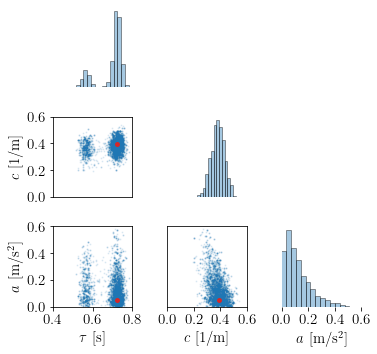

In [11]:
## plot MAP/Mean/STD Simu
dim = 3
results_fname = "combined\\power_limit\samples_3param_2modes_std02.p"
# results_fname = "combined\\power_limit\samples_3param_PL_acc_std01.p"
[dram_samples,dram_ar,map_point,cov_laplace] = pickle.load(open(results_fname, "rb" ))
print(dram_ar)
samples_sub = sub_sample_data(dram_samples, frac_burn=0.5, frac_use=0.9)

plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize

fig, axs, gs = scatter_matrix([samples_sub], labels=
                              [r'$\tau$ $\mathrm{[s]}$', '$c$ $\mathrm{[1/m]}$', '$a$ $\mathrm{[m/s^2]}$'], 
                              hist_plot=False, gamma=0.1, nbins=70)
axs[0].set_xlim((0.4,0.8))     # tau
axs[1].set_xlim((0,0.6))       # c
axs[2].set_xlim((0,0.6))         # a
axs[2].set_xticks((0,0.2,0.4,0.6))

axs[3].set_ylim((0,0.6)) # top tau-c
axs[3].set_yticks((0,0.2,0.4,0.6))
axs[3].set_xlim((0.4,0.8))
axs[3].scatter(map_point[0],map_point[1],s=15,c = '#d62728',zorder=5000)
axs[3].set_rasterized(True)

axs[6].set_ylim((0,0.6)) # mid 1  tau-a
axs[6].set_yticks((0,0.2,0.4,0.6))
axs[6].set_xlim((0.4,0.8))
axs[6].set_xticks((0.4,0.6,0.8))
axs[6].scatter(map_point[0],map_point[2],s=15,c = '#d62728',zorder=5000)
axs[6].set_rasterized(True)

axs[7].set_ylim((0,0.6)) # mid  c-a
axs[7].set_xlim((0,0.6))
axs[7].set_xticks((0,0.2,0.4,0.6))
axs[7].scatter(map_point[1],map_point[2],s=15,c = '#d62728',zorder=5000)
axs[7].set_rasterized(True)



fig.set_size_inches(5.5,5.5)
plt.tight_layout(rect=[0, 0.01, 1, 0.95])
plt.savefig('figures\marginal_'+str(dim)+'param_com_PL.svg',dpi=500)

mean = np.mean(samples_sub,axis = 0)
median = np.median(samples_sub,axis = 0)
theta_cov = np.cov(samples_sub.T)
theta_std = np.sqrt(np.diag(theta_cov))
theta_quant95 = np.quantile(samples_sub,0.95,axis = 0)
theta_quant05 = np.quantile(samples_sub,0.05,axis = 0)
print('MAP: {}'.format(map_point) )
print('mean: {}'.format(mean))
print('median: {}'.format(median))
print('quantile05: {}'.format(theta_quant05))
print('quantile95: {}'.format(theta_quant95))

In [ ]:
yy_median = ddeint(CAV_3param, g, tsim, fargs=median.tolist())
yy_upb = ddeint(CAV_3param, g, tsim, fargs=theta_quant95.tolist())
yy_lwb = ddeint(CAV_3param, g, tsim, fargs=theta_quant05.tolist())
MSE_h = np.sum((yy_median[:,0]-data_h_single[int(taumax/0.1):-1])**2)/yy_median.shape[0]
MSE_v = np.sum((yy_median[:,1]-data_v_single[int(taumax/0.1):-1])**2)/yy_median.shape[0]

yy_map = ddeint(CAV_3param, g, tsim, fargs=map_point.tolist())
MSE_h_map = np.sum((yy_map[:,0]-data_h_single[int(taumax/0.1):-1])**2)/yy_map.shape[0]
MSE_v_map = np.sum((yy_map[:,1]-data_v_single[int(taumax/0.1):-1])**2)/yy_map.shape[0]

print(np.sqrt(MSE_h))
print(np.sqrt(MSE_v))
matplotlib.rc('text', usetex = True)
fig,axs = plt.subplots(2, 1, figsize=(6.5, 4))
# headway 
axs[0].scatter(tt_single,data_h_single, label = 'data',alpha = 0.3,s = 10)
axs[0].plot(tsim,yy_median[:,0],'red',ls ='-', label = 'mean simulation',linewidth=2)
axs[0].fill_between(tsim,yy_upb[:,0], yy_lwb[:,0],label = r'$\pm 2std$', alpha=0.4)
axs[0].plot(tsim,yy_map[:,0],'black',ls ='--', label = 'MAP simulation',linewidth=2)
# axs[0].set_title(r'$\tau$ = {:.2f}$\pm2${:.2f}, $a$ = {:.2f}$\pm 2${:.2f}, $b$ = {:.3f}$\pm2${:.3f}, $c$ = {:.2f}$\pm2${:.2f}'.format(
#     theta[0],theta_std[0],theta[3],theta_std[3],theta[2],theta_std[2],theta[1],theta_std[1]))
axs[0].set_ylabel(r'$h\mathrm{\ [m]}$')
# velocity
axs[1].scatter(tt_single,data_v_single,label = r'$\mathrm{data}$',alpha = 0.3,s = 10)
axs[1].plot(tsim,yy_median[:,1], 'red', ls ='-', label = r'$\mathrm{median\ sim}$',linewidth=2)
axs[1].fill_between(tsim,yy_upb[:,1], yy_lwb[:,1],label = r'$\mathrm{median} \pm \mathrm{0.45 quantile\ sim}$',alpha=0.4)
axs[1].set_ylabel(r'$v\mathrm{\ [m/s]}$')
axs[1].plot(tsim,yy_map[:,1], 'black', ls ='--',label = r'$\mathrm{MAP\ sim}$',linewidth=2)
axs[1].set_xlabel(r'$t\mathrm{\ [s]}$')
# axs[1].set_title(r'$h^*$ = {} m; mean $MSE_h$ = {:.3f},$MSE_v$ = {:.3f}; MAP $MSE_h$ = {:.3f},$MSE_v$ = {:.3f}'.format(h_ave, MSE_h,MSE_v,MSE_h_map,MSE_v_map))
axs[1].legend(ncol=2)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('figures\hstar'+str(h_ave)+'_'+str(dim)+'param_simu_com_PL.svg')

0.2544254425442544


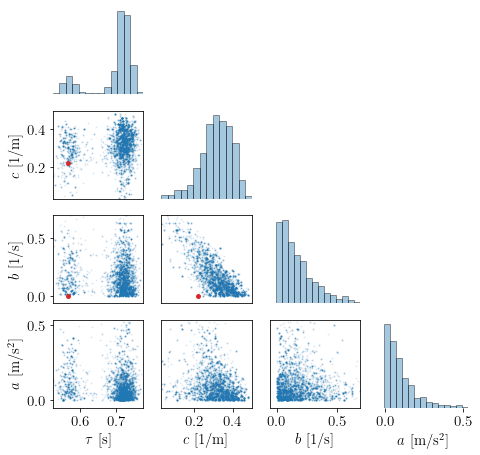

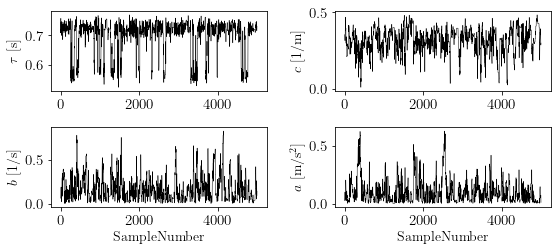

In [44]:
## plot MAP/Mean/STD Simu
dim = 4
# results_fname = "combined\\power_limit\samples_4param_2modes_std02.p"
results_fname = "combined\\power_limit\samples_4param_PL_std02_uni.p"
[dram_samples,dram_ar,map_point,cov_laplace] = pickle.load(open(results_fname, "rb" ))
print(dram_ar)
samples_sub = sub_sample_data(dram_samples, frac_burn=0.5, frac_use=0.9)

plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize

fig, axs, gs = scatter_matrix([samples_sub], labels=
                              [r'$\tau$ $\mathrm{[s]}$', '$c$ $\mathrm{[1/m]}$', '$b$ $\mathrm{[1/s]}$', '$a$ $\mathrm{[m/s^2]}$'], 
                              hist_plot=False, gamma=0.1, nbins=70)
# axs[0].set_xlim((0.4,0.8))
# axs[1].set_xlim((0,0.6))
# axs[2].set_xlim((0,0.8))
# axs[3].set_xlim((0,0.6))
# axs[3].set_xticks((0,0.2,0.4,0.6))

# axs[4].set_ylim((0,0.6)) # top tau-c
# axs[4].set_yticks((0,0.2,0.4,0.6))
# axs[4].set_xlim((0.4,0.8))
axs[4].scatter(map_point[0],map_point[1],s=15,c = '#d62728',zorder=5000)
axs[4].set_rasterized(True)

# axs[8].set_ylim((0,0.8)) # mid 1  tau-b
# axs[8].set_yticks((0,0.4,0.8))
# axs[8].set_xlim((0.4,0.8))
axs[8].scatter(map_point[0],map_point[2],s=15,c = '#d62728',zorder=5000)
axs[8].set_rasterized(True)

# axs[9].set_ylim((0,0.8)) # mid  c-b
# axs[9].set_xlim((0,0.6))
axs[9].scatter(map_point[1],map_point[2],s=15,c = '#d62728',zorder=5000)
axs[9].set_rasterized(True)


# axs[12].set_ylim((0,0.6)) # bot 1 tau-a
# axs[12].set_yticks((0,0.2,0.4,0.6))
# axs[12].set_xlim((0.4,0.8))
# axs[12].set_xticks((0.4,0.6,0.8))
axs[12].scatter(map_point[0],map_point[3],s=15,c = '#d62728',zorder=5000)
axs[12].set_rasterized(True)

# axs[13].set_ylim((0,0.6))
# axs[13].set_xlim((0,0.6)) # bot 2 c-a
# axs[13].set_xticks((0,0.2,0.4,0.6)) # bot 2
axs[13].scatter(map_point[1],map_point[3],s=15,c = '#d62728',zorder=5000)
axs[13].set_rasterized(True)

# axs[14].set_ylim((0,0.6))
# axs[14].set_xlim((0,0.8)) # bot 3 b-a
# axs[14].set_xticks((0,0.4,0.8)) # bot 3
axs[14].scatter(map_point[2],map_point[3],s=15,c = '#d62728',zorder=5000)
axs[14].set_rasterized(True)

fig.set_size_inches(7,7)
plt.tight_layout(rect=[0, 0.01, 1, 0.95])
plt.savefig('figures\marginal_'+str(dim)+'param_com_PL.svg',dpi=500)

fig, axs = plt.subplots(2,2, figsize=(8,4))
axs[0,0].plot(samples_sub[:, 0], '-k',lw=0.5)
axs[0,0].set_ylabel(r'$\tau$ $\mathrm{[s]}$', fontsize=14)
# axs[0,0].set_yticks((0.4,0.6,0.8))

axs[0,1].plot(samples_sub[:, 1], '-k',lw=0.5)
axs[0,1].set_ylabel(r'$c$ $\mathrm{[1/m]}$', fontsize=14)
# axs[0,1].set_yticks((0,0.2,0.4,0.6))

axs[1,0].plot(samples_sub[:, 2], '-k',lw=0.5)
axs[1,0].set_ylabel('$b$ $\mathrm{[1/s]}$', fontsize=14)
# axs[1,0].set_yticks((0,0.5,1,1.5))
axs[1,0].set_xlabel('$\mathrm{Sample Number}$', fontsize=14)

axs[1,1].plot(samples_sub[:, 3], '-k',lw=0.5)
# axs[1,1].set_yticks((0,0.5,1))
axs[1,1].set_ylabel('$a$ $\mathrm{[m/s^2]}$', fontsize=14)
axs[1,1].set_xlabel('$\mathrm{Sample Number}$', fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('figures\inspect_'+str(dim)+'param_com_PL.svg')

In [30]:
mean = np.mean(samples_sub,axis = 0)
median = np.median(samples_sub,axis = 0)
theta_cov = np.cov(samples_sub.T)
theta_std = np.sqrt(np.diag(theta_cov))
theta_quant95 = np.quantile(samples_sub,0.95,axis = 0)
theta_quant05 = np.quantile(samples_sub,0.05,axis = 0)
print('MAP: {}'.format(map_point) )
print('mean: {}'.format(mean))
print('median: {}'.format(median))
print('quantile05: {}'.format(theta_quant05))
print('quantile95: {}'.format(theta_quant95))

MAP: [7.23367923e-01 4.80987535e-02 7.52664931e-01 1.25555149e-08]
mean: [0.72384504 0.37256182 0.05102965 0.02297619]
median: [0.72427596 0.37427332 0.03403807 0.01728421]
quantile05: [0.71025337 0.31972504 0.00271034 0.00147938]
quantile95: [0.73690347 0.41845742 0.15247036 0.06869794]


9.834079812242475
0.5287467499048001
9.552611140247736
0.5059170999002203


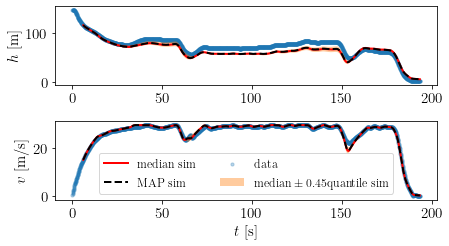

In [42]:
# simulation 
h_ave = 50
fname = 'data\RealAVData\RealAVhstar'+str(h_ave)+'.mat'
data = loadmat(fname)['D']
'''first column is headway of CAV, second column is the speed difference,
third column is the velocity of CAV and last column is the acceleration of CAV.'''
Npts_single = len(data)
dt = 0.1
st = 0
data_h_single = data[st:st+Npts_single,0]                      # inference from h0
data_vl_single = data[st:st+Npts_single,1]+data[st:st+Npts_single,2]  # input to the system
data_v_single = data[st:st+Npts_single,2]                      # or inference from v0
data_dv_single = np.diff(data_v_single)/dt
data_dh_single = np.diff(data_h_single)/dt
tt_single = np.linspace(st*0.1, (st+Npts_single)*0.1, num=Npts_single)  # reference time
tsim = np.linspace(st*0.1+taumax, st*0.1+(Npts_single-1)*0.1, num=Npts_single-1-int(taumax/0.1))   # simulation time
vLfun = lambda t:np.interp(t, tt_single, data_vl_single)
g = lambda t: np.array([np.interp(t, tt_single, data_h_single),np.interp(t, tt_single, data_v_single)])  # history

yy_median = ddeint(CAV_4param, g, tsim, fargs=median.tolist())
yy_upb = ddeint(CAV_4param, g, tsim, fargs=theta_quant95.tolist())
yy_lwb = ddeint(CAV_4param, g, tsim, fargs=theta_quant05.tolist())
MSE_h = np.sum((yy_median[:,0]-data_h_single[int(taumax/0.1):-1])**2)/yy_median.shape[0]
MSE_v = np.sum((yy_median[:,1]-data_v_single[int(taumax/0.1):-1])**2)/yy_median.shape[0]

yy_map = ddeint(CAV_4param, g, tsim, fargs=map_point.tolist())
MSE_h_map = np.sum((yy_map[:,0]-data_h_single[int(taumax/0.1):-1])**2)/yy_map.shape[0]
MSE_v_map = np.sum((yy_map[:,1]-data_v_single[int(taumax/0.1):-1])**2)/yy_map.shape[0]

matplotlib.rc('text', usetex = True)
fig,axs = plt.subplots(2, 1, figsize=(6.5, 4))
# headway 
axs[0].scatter(tt_single,data_h_single, label = 'data',alpha = 0.3,s = 10)
axs[0].plot(tsim,yy_median[:,0],'red',ls ='-', label = 'mean simulation',linewidth=2)
axs[0].fill_between(tsim,yy_upb[:,0], yy_lwb[:,0],label = r'$\pm 2std$', alpha=0.4)
axs[0].plot(tsim,yy_map[:,0],'black',ls ='--', label = 'MAP simulation',linewidth=2)
# axs[0].set_title(r'$\tau$ = {:.2f}$\pm2${:.2f}, $a$ = {:.2f}$\pm 2${:.2f}, $b$ = {:.3f}$\pm2${:.3f}, $c$ = {:.2f}$\pm2${:.2f}'.format(
#     theta[0],theta_std[0],theta[3],theta_std[3],theta[2],theta_std[2],theta[1],theta_std[1]))
axs[0].set_ylabel(r'$h\mathrm{\ [m]}$')
# velocity
axs[1].scatter(tt_single,data_v_single,label = r'$\mathrm{data}$',alpha = 0.3,s = 10)
axs[1].plot(tsim,yy_median[:,1], 'red', ls ='-', label = r'$\mathrm{median\ sim}$',linewidth=2)
axs[1].fill_between(tsim,yy_upb[:,1], yy_lwb[:,1],label = r'$\mathrm{median} \pm \mathrm{0.45 quantile\ sim}$',alpha=0.4)
axs[1].set_ylabel(r'$v\mathrm{\ [m/s]}$')
axs[1].plot(tsim,yy_map[:,1], 'black', ls ='--',label = r'$\mathrm{MAP\ sim}$',linewidth=2)
axs[1].set_xlabel(r'$t\mathrm{\ [s]}$')
# axs[1].set_title(r'$h^*$ = {} m; mean $MSE_h$ = {:.3f},$MSE_v$ = {:.3f}; MAP $MSE_h$ = {:.3f},$MSE_v$ = {:.3f}'.format(h_ave, MSE_h,MSE_v,MSE_h_map,MSE_v_map))
axs[1].legend(ncol=2)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('figures\hstar'+str(h_ave)+'_'+str(dim)+'param_simu_com_PL.svg')
print(np.sqrt(MSE_h))
print(np.sqrt(MSE_v))

print(np.sqrt(MSE_h_map))
print(np.sqrt(MSE_v_map))



## Marginal likelihood

In [117]:
results_fname = "combined\\no_power_limit\samples_2param.p"
[dram_samples,dram_ar,map_point,cov_laplace] = pickle.load(open(results_fname, "rb" ))
samples_sub = sub_sample_data(dram_samples, frac_burn=0.5, frac_use=0.7)

marginal_like_c = 0
for i in range(5):
    like_log = dvdt_log_likelihood_2d(samples_sub[i,:],CAV_2dvdt_2d, observe_funs, Npts, taumax,output_2d, guess_noise_var)
    print(np.exp(like_log))
    marginal_like_c = marginal_like_c + np.exp(like_log)


0.0
0.0
0.0
0.0
0.0


In [ ]:
results_fname = "combined\\power_limit\samples_3param.p"
[dram_samples,dram_ar,map_point,cov_laplace] = pickle.load(open(results_fname, "rb" ))
samples_sub = sub_sample_data(dram_samples, frac_burn=0.5, frac_use=0.7)

marginal_like_ca = 0
for i in range(5):
    like_log = dvdt_log_likelihood_2d(samples_sub[i,:],CAV_3dvdt_2d, observe_funs, Npts, taumax,output_2d, guess_noise_var)
    marginal_like_c = marginal_like_c + np.exp(like_log)
print(marginal_like_c)  

In [73]:
results_fname = "combined\\power_limit\samples_4param.p"
[dram_samples,dram_ar,map_point,cov_laplace] = pickle.load(open(results_fname, "rb" ))
samples_sub = sub_sample_data(dram_samples, frac_burn=0.5, frac_use=0.7)

marginal_like_c = 0
for i in range(5):
    like_log = dvdt_log_likelihood_2d(samples_sub[i,:],CAV_4dvdt_2d, observe_funs, Npts, taumax,output_2d, guess_noise_var)
    marginal_like_c = marginal_like_c + np.exp(like_log)
print(marginal_like_c)  

0.0


## Outliner dataset

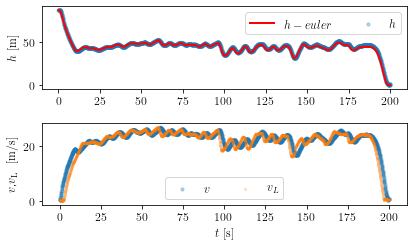

In [17]:
# simulation 
h_ave = 30
fname = 'data\RealAVData\RealAVhstar'+str(h_ave)+'.mat'
data = loadmat(fname)['D']
'''first column is headway of CAV, second column is the speed difference,
third column is the velocity of CAV and last column is the acceleration of CAV.'''
Npts_single = len(data)
dt = 0.1
st = 0
data_h_single = data[st:st+Npts_single,0]                      # inference from h0
data_vl_single = data[st:st+Npts_single,1]+data[st:st+Npts_single,2]  # input to the system
data_v_single = data[st:st+Npts_single,2]                      # or inference from v0
data_dv_single = np.diff(data_v_single)/dt
data_dh_single = np.diff(data_h_single)/dt

h_euler = data_h_single[0]+np.cumsum((data_vl_single-data_v_single)*dt)

tt = np.linspace(st*0.1, (st+Npts_single)*0.1, num=Npts_single-1)  # reference time
fig,axs = plt.subplots(2, 1, figsize=(6, 4))
# headway 
axs[0].scatter(tt,data_h_single[:-1], label = '$h$',alpha = 0.3,s = 10)
axs[0].plot(tt,h_euler[:-1], 'red', ls ='-',label = '$h-euler$',linewidth=2)
axs[0].legend(ncol=2)
axs[0].set_ylabel(r'$h\mathrm{\ [m]}$')
# velocity
axs[1].scatter(tt,data_v_single[:-1],label = r'$v$',alpha = 0.3,s = 10)
axs[1].scatter(tt,data_vl_single[:-1],label = r'$v_L$',alpha = 0.2,s = 5)
axs[1].set_ylabel(r'$v$,$v_{\rm L}$ $\mathrm{\ [m/s]}$')
axs[1].set_xlabel('$t\mathrm{\ [s]}$')
axs[1].legend(ncol=2)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [149]:
Npts

array([360, 360, 360, 360, 360, 360, 360])